In [1]:
from GMM import GMM
from gen_data import generate_multimodal_data, generate_means_stds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

# GMM visualization

## Simple gaussians

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_25491/234265166.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


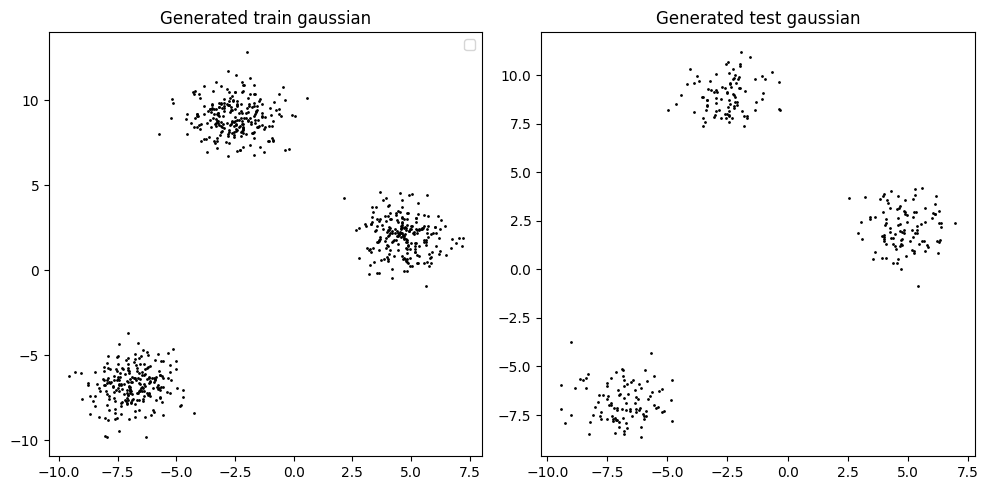

In [38]:
# Generate a multimodal dataset
OMP_NUM_THREADS=1
X, y = generate_multimodal_data(n_samples=1000, n_features=2, n_classes=1, n_clusters_per_class=3)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Generated train gaussian")
plt.scatter(X_train[:, 0], X_train[:, 1], s=1, c="black")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Generated test gaussian")
plt.scatter(X_test[:, 0], X_test[:, 1], s=1, c="black")

plt.tight_layout()
plt.show()

In [30]:
gmm_classifier = GMM(n_components=3, tol=0)
gmm_classifier.fit(X_train)

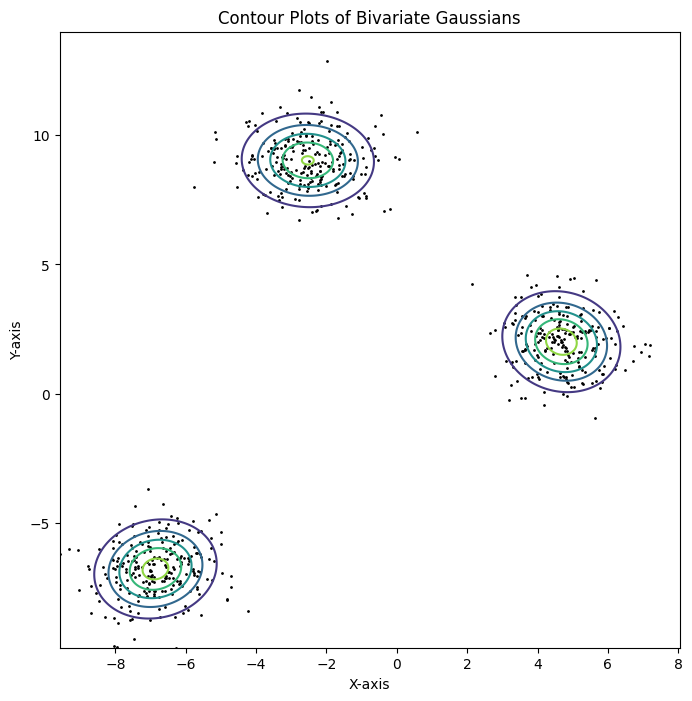

In [39]:
x, y = np.mgrid[min(X_train[:, 0]):max(X_train[:, 0]):.01, min(X_train[:, 1]):max(X_train[:, 1]):.01]
pos = np.dstack((x, y))
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], s=1, c="black")

# # Plot contours for each mean and covariance
for mean, cov in zip(gmm_classifier.means_, gmm_classifier.covariances_):
    rv = multivariate_normal(mean, cov)
    plt.contour(x, y, rv.pdf(pos), levels=5)


# # Add labels and grid
plt.title("Contour Plots of Bivariate Gaussians")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(False)
plt.show()


## Overlaping gaussians

/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_25491/3382741830.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


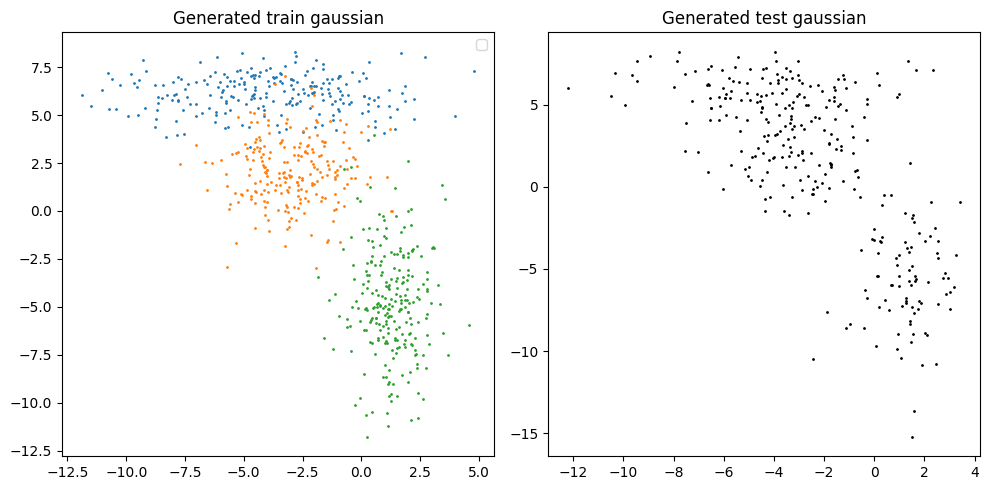

In [94]:
# Generate a multimodal dataset
OMP_NUM_THREADS=1
X, y, c = make_blobs(n_samples=1000, n_features=2, centers=[[-4.0, 6.2],[-3, 2],[ 1.2,-4.9]],
                      cluster_std=[[3.0, 1.], [1.6, 1.8], [1., 3.0]], random_state=69, return_centers=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Generated train gaussian")
for col, cls in zip(["tab:blue", "tab:orange", "tab:green"], range(3)):
    plt.scatter(X_train[y_train==cls, 0], X_train[y_train==cls, 1],  s=1, c=col)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Generated test gaussian")
plt.scatter(X_test[:, 0], X_test[:, 1],  s=1, c="black")

plt.tight_layout()
plt.show()

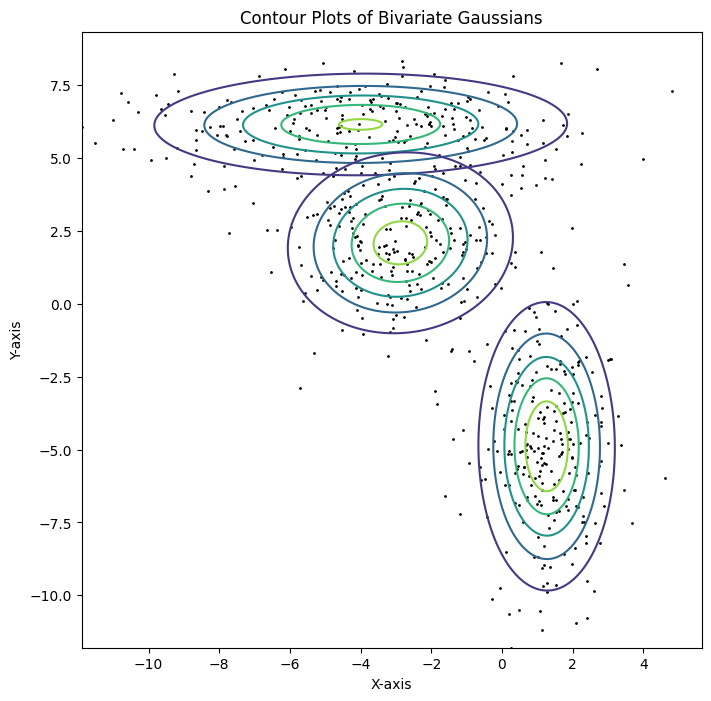

In [98]:
gmm_classifier = GMM(n_components=3, tol=0)
gmm_classifier.fit(X_train)

x, y = np.mgrid[min(X_train[:, 0]):max(X_train[:, 0]):.01, min(X_train[:, 1]):max(X_train[:, 1]):.01]
pos = np.dstack((x, y))
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], s=1, c="black")

# # Plot contours for each mean and covariance
for mean, cov in zip(gmm_classifier.means_, gmm_classifier.covariances_):
    rv = multivariate_normal(mean, cov)
    plt.contour(x, y, rv.pdf(pos), levels=5)


# # Add labels and grid
plt.title("Contour Plots of Bivariate Gaussians")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(False)
plt.show()

# Initialization experiments

## k-means

In [13]:
ggm_acc = []
ggm_k_acc = []

for _ in range(100):
    means, stds = generate_means_stds(n_components=3, n_features=2)
    X, y = make_blobs(n_samples=1000, n_features=2, centers=means,
                      cluster_std=stds, random_state=69)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    gmm = GMM(n_components=3, tol=0)
    gmm_k = GMM(n_components=3, tol=0, km_init=True)
    
    gmm.fit(X_train)
    gmm_k.fit(X_train)

    y_pred = gmm.predict(X_test)
    y_pred_k = gmm_k.predict(X_test)
    # calibrate y_pred and y
    # measure accuracies over predictions ?
    # measure mse over means and cov ?
    # measure ce ?
    print(y_pred)
    print(y_test)
    break
    

[2 1 0 2 2 1 0 2 0 2 1 2 2 1 2 2 0 0 2 0 2 0 0 0 0 0 0 0 1 1 2 0 1 1 0 2 1
 1 1 2 0 2 1 2 0 2 0 1 0 1 2 2 1 1 1 0 0 1 1 1 1 2 1 1 2 1 2 0 0 2 0 2 2 2
 0 0 2 2 1 0 0 0 1 2 1 2 1 1 1 0 1 1 2 0 2 1 1 2 0 2 2 2 2 0 0 0 2 2 2 1 0
 2 0 1 0 1 0 2 1 1 2 1 2 1 2 1 2 0 2 1 0 1 0 1 0 2 2 0 0 0 1 0 0 1 1 1 0 1
 0 0 1 0 2 2 1 0 1 0 1 0 1 1 2 2 2 1 2 1 2 2 1 1 1 2 1 0 2 1 1 1 2 1 2 2 0
 1 2 1 0 0 1 1 1 2 1 1 2 2 2 0 0 0 0 0 0 1 1 2 1 1 1 2 1 1 1 1 1 2 2 0 0 0
 0 1 0 0 1 1 2 2 0 0 2 0 1 1 1 1 1 1 2 2 1 1 2 0 1 0 1 1 0 2 0 2 0 1 2 1 0
 2 0 1 2 0 2 2 1 1 2 1 0 0 0 1 2 1 1 2 1 2 2 2 2 0 2 0 0 1 0 1 1 2 2 0 2 0
 2 1 0 2]
[0 1 2 0 0 1 2 1 2 0 1 0 0 1 0 0 2 2 0 2 0 2 2 2 2 2 2 2 1 1 0 2 1 1 2 0 1
 1 1 1 2 0 1 0 2 0 2 1 2 1 0 0 1 1 1 2 2 1 1 1 1 0 1 1 0 1 0 2 2 0 2 0 0 0
 2 2 0 1 1 2 2 2 1 0 1 1 1 1 1 2 1 1 0 2 0 1 1 0 2 0 2 0 0 2 2 2 0 1 0 1 2
 0 2 1 2 1 2 0 1 1 0 1 0 1 0 1 0 2 0 1 2 1 2 0 2 0 0 2 2 2 1 2 2 1 1 1 2 1
 2 2 1 2 0 0 1 2 1 2 1 2 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 2 0 1 1 1 0 1 0 0 2
 1 0 1 2 2 1 1 